# Actividad 7 - Regresión Poisson y Binomial Negativa

Cargamos el excel y lo guardamos en la variable _datos_

In [2]:
library(readxl)
if (.Platform$OS.type=="unix"){ ruta_excel <- "datasets/cancer de piel datos.xlsx"
} else ruta_excel <- "../datasets/cancer de piel datos.xlsx"

datos <- read_excel(ruta_excel, sheet="Sheet1 (2)")
datos$cd <- as.factor(datos$cd) 
datos$age <- as.factor(datos$age)
head(datos, n=3)

age,cases,psize,cd
<fct>,<dbl>,<dbl>,<fct>
85,40,8328,1 Minesota
75-84,133,32185,1 Minesota
65-74,130,54722,1 Minesota


Graficamos nuestros datos en función de la tasa de ocurrencia para ver cómo están distribuidos:

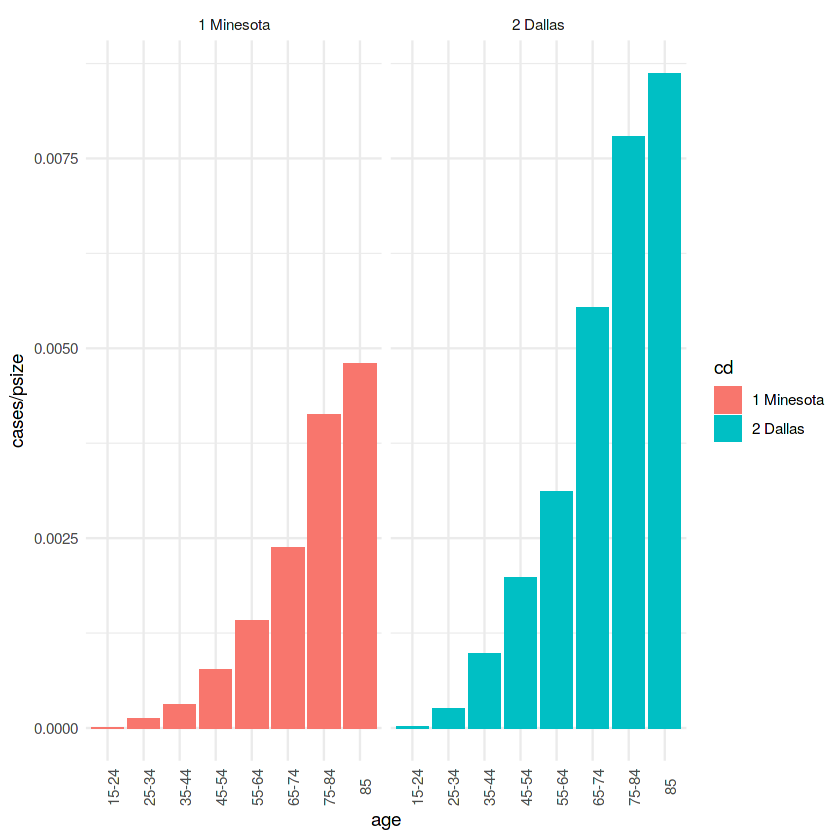

In [2]:
suppressPackageStartupMessages(library(ggplot2))
ggplot(data=datos, aes(x=age, y=cases/psize, fill=cd)) +
    geom_col() + theme_minimal() + 
    theme(axis.text.x = element_text(angle = 90)) +
    facet_wrap(~cd)

Como la variable de interés es la tasa de casos $(\frac{cases}{psize})$, se tiene la fórmula:

> $ \log{(\frac{cases}{psize})} = \beta_0 + \sum_i {\beta_i X_i} $

Despejando el _offset_:

> \( log(cases) - log(psize) = \beta_0 + \sum_i {\beta_i X_i} \)

> \( log(cases) = log(psize) + \beta_0 + \sum_i {\beta_i X_i} \)

Por lo tanto, el offset es $log(psize)$

La fórmula para el cálculo de la dispersión es:

dispersion = $\frac{\chi^2}{df}$

Por lo tanto, definimos la función para reusarla más adelante:

In [3]:
calcula_disp <- function(mi_lm){
    chisq_pearson <- sum(residuals(mi_lm, type="pearson")^2)
    return (chisq_pearson / mi_lm$df.residual)
}

Calculamos el modelo poisson definiendo log(psize) como offset:

In [4]:
canpiel_lm <- glm(formula = cases ~ cd + age + offset( log(psize) ),
    data=datos, family=poisson(link = "log"), control=list(maxit = 50))
summary(canpiel_lm)


Call:
glm(formula = cases ~ cd + age + offset(log(psize)), family = poisson(link = "log"), 
    data = datos, control = list(maxit = 50))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5043  -0.4816   0.0169   0.3697   1.2504  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -11.65787    0.44871 -25.981  < 2e-16 ***
cd2 Dallas    0.80428    0.05221  15.406  < 2e-16 ***
age25-34      2.63019    0.46746   5.627 1.84e-08 ***
age35-44      3.84735    0.45466   8.462  < 2e-16 ***
age45-54      4.59519    0.45103  10.188  < 2e-16 ***
age55-64      5.08728    0.45030  11.298  < 2e-16 ***
age65-74      5.64541    0.44975  12.552  < 2e-16 ***
age75-84      6.05855    0.45032  13.454  < 2e-16 ***
age85         6.17819    0.45774  13.497  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2790.340  on 15  degrees of freedom
Residual dev

Como tenemos _valores p_ muy pequeños, verificamos si hay sobredispersión: 

In [6]:
calcula_disp(canpiel_lm)

[1] 1.151803

Para los modelos Poisson, también se puede verificar con la función dispersion test de la librería AER:

In [7]:
AER::dispersiontest(canpiel_lm) # Regresa el valor de dispersión -1

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4
Registered S3 method overwritten by 'AER':
  method       from   
  nobs.survreg insight



	Overdispersion test

data:  canpiel_lm
z = -2.9865, p-value = 0.9986
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
 0.5179961 


Como hay sobredispersión, también calculamos el modelo cuasipoisson:

In [8]:
# Offset puede ser definido como:
# - resp ~ variables + offset(var offset)
# - o como parámetro de la función glm
canpiel_lmqp <- glm(formula= cases ~ cd + age, offset = log(psize),    
    data=datos, family=quasipoisson(link = "log"), control = list(maxit = 50))

Comparamos el modelo anterior contra el cuasipoisson:

In [9]:
anova(canpiel_lm, canpiel_lmqp, test="Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,8.19505,NA,NA,NA
7,8.19505,0,0,NA


Parece que no hay cambios.

Calculamos la dispersión para el nuevo modelo:

In [10]:
# AER::dispersiontest(modelo) sólo sirve para Poisson GLMs
calcula_disp(canpiel_lmqp)

[1] 1.151803

Vemos que nos da el mismo resultado de _sobredispersión_ que el modelo _Poisson_ anterior. Por lo tanto, hacemos nuestro modelo con la regresión binomial negativa:

In [11]:
canpiel_nb <- MASS::glm.nb(formula= cases ~ cd + age + offset(log(psize)),
    data=datos, control=glm.control(maxit=150), link=log)

Calculamos la dispersión para el nuevo modelo.

In [12]:
calcula_disp(canpiel_nb)

[1] 1.151803

Verificamos los modelos:

In [13]:
anova(canpiel_lm, canpiel_lmqp, canpiel_nb, test="Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,8.19505,NA,NA,NA
7,8.19505,0,0.000000e+00,NA
7,8.19505,0,4.949266e-09,NA


Calculando los coeficientes exponenciados:

In [14]:
broom::tidy(canpiel_nb, exponentiate = TRUE, conf.int = TRUE, conf.level = 0.95)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),8.650664e-06,0.44870950,-25.980895,8.142527e-149,3.094580e-06,1.865750e-05
cd2 Dallas,2.235075e+00,0.05220539,15.405976,1.492198e-53,2.019074e+00,2.477692e+00
age25-34,1.387643e+01,0.46746149,5.626542,1.838575e-08,6.128135e+00,3.984269e+01
age35-44,4.686883e+01,0.45465935,8.462056,2.627044e-17,2.139976e+01,1.321343e+02
age45-54,9.900654e+01,0.45102873,10.188233,2.237938e-24,4.563038e+01,2.776803e+02
age55-64,1.619490e+02,0.45030105,11.297512,1.349878e-29,7.477971e+01,4.537333e+02
age65-74,2.829908e+02,0.44974750,12.552409,3.855982e-36,1.308569e+02,7.922290e+02
age75-84,4.277533e+02,0.45032042,13.453857,2.922215e-41,1.975048e+02,1.198477e+03
age85,4.821178e+02,0.45774076,13.497134,1.625787e-41,2.183764e+02,1.365244e+03


Graficamos el modelo:

Warning message:
"Removed 2 rows containing missing values (geom_errorbar)."

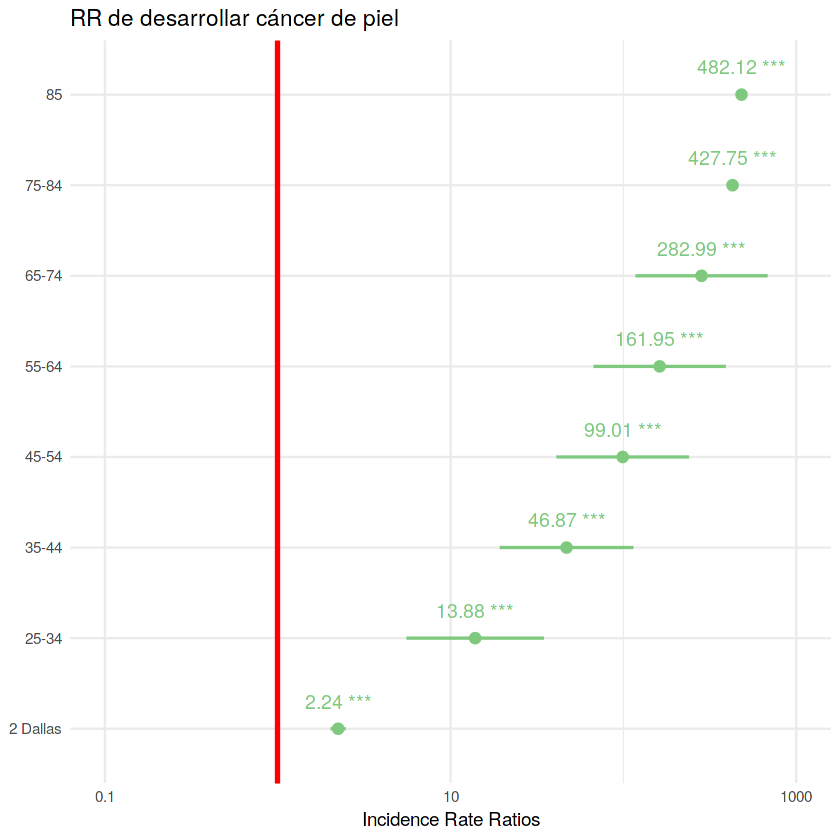

In [15]:
suppressPackageStartupMessages(library(sjPlot))

plot_model(canpiel_nb, vline.color="red", show.values = TRUE, value.offset=.3,
    sort.est=TRUE, colors = "Accent", title="RR de desarrollar cáncer de piel")+
    theme_minimal()

Hacemos la prueba de hipótesis para los coeficientes de las variables:

$H_{0}$: $\beta_{1}=...=\beta_{n}= 0$

$H_{a}$: No existe $\beta_{n} = 0$

In [16]:
car::Anova(canpiel_nb, type=3)

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
cd,258.7193,1,3.263444e-58
age,2561.5750,7,0.000000e+00


Por lo tanto no se tiene suficiente evidencia como para rechazar la hipótesis nula y concluímos que las dos variables usadas en el modelo son significativas.

De los coeficientes (y gráfico de RR) se obtiene que el riesgo de desarrollar cáncer de piel aumenta en Dallas (en comparación de Minesota), así como también aumenta el riesgo al haber un aumento de edad.

Notas:

  - La explicación de la fórmula offset está [aquí](https://rpubs.com/kaz_yos/poisson)
  - La personalización de colores de sjPlot::plot_model está [aquí](https://cran.r-project.org/web/packages/sjPlot/vignettes/plot_model_estimates.html)

## Haciendo el método stepwise para el modelo:

In [21]:
mod_saturado <- glm(formula= cases ~ cd * age, offset=log(psize), data=datos, 
    family=poisson(link = "log"), control = list(maxit = 50))
mod_nulo <- glm(formula= cases ~ 1, offset=log(psize), data=datos, family=poisson(link = "log"),
    control = list(maxit = 50))
mod_stepwise <- 
MASS::stepAIC( 
    mod_nulo, # Modelo con el que iniciará las iteraciones de los modelos.
    trace = T, # Imprimir iteraciones
    criterion = c("AIC"), # AIC/BIC *Aunque siempre imprime AIC
    direction="both", # "backward/forward"
    scope=list(upper=mod_saturado, lower=mod_nulo) # Límites de modelos
) # Regresa modelo seleccionado

Start:  AIC=2886.59
cases ~ 1

       Df Deviance     AIC
+ age   7   266.91  377.16
+ cd    1  2569.77 2668.02
<none>     2790.34 2886.59

Step:  AIC=377.16
cases ~ age

       Df Deviance     AIC
+ cd    1     8.20  120.44
<none>      266.91  377.16
- age   7  2790.34 2886.59

Step:  AIC=120.44
cases ~ age + cd

         Df Deviance     AIC
<none>          8.20  120.44
+ cd:age  7     0.00  126.25
- cd      1   266.91  377.16
- age     7  2569.77 2668.02


In [23]:
calcula_disp(mod_stepwise)

[1] 1.151803

In [3]:
canpiel_lm <- glm(formula = cases ~ cd + age + offset( log(psize) ),
    data=datos, family=poisson(link = "log"), control=list(maxit = 50))
ummary(canpiel_lm)


Call:
glm(formula = cases ~ cd + age + offset(log(psize)), family = poisson(link = "log"), 
    data = datos, control = list(maxit = 50))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5043  -0.4816   0.0169   0.3697   1.2504  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -11.65787    0.44871 -25.981  < 2e-16 ***
cd2 Dallas    0.80428    0.05221  15.406  < 2e-16 ***
age25-34      2.63019    0.46746   5.627 1.84e-08 ***
age35-44      3.84735    0.45466   8.462  < 2e-16 ***
age45-54      4.59519    0.45103  10.188  < 2e-16 ***
age55-64      5.08728    0.45030  11.298  < 2e-16 ***
age65-74      5.64541    0.44975  12.552  < 2e-16 ***
age75-84      6.05855    0.45032  13.454  < 2e-16 ***
age85         6.17819    0.45774  13.497  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2790.340  on 15  degrees of freedom
Residual dev

In [4]:
anova(canpiel_lm)

,Df,Deviance,Resid. Df,Resid. Dev
,<int>,<dbl>,<int>,<dbl>
NULL,NA,NA,15,2790.34029
cd,1,220.5703,14,2569.77001
age,7,2561.5750,7,8.19505


- Poisson es para medidas pequeñas
- Significancia es la prueba de Wald
- En Poisson es que aumenta el número de casos.
- Estimadores marginales - fitted(data_pm)
- Estimar la bondad de ajuste = valores observados vs valores estimados
- Anova
	Tipo 2 - Sólo variables principales
	Tipo 3 - Sólo variables principales + interacciones
- Devianza es la varianza para la regresión	(Ji^2 de razón de verosimilitud)
- Anova lo del modelo sumado más o menos parecido a la devianza nula (LR = Likelihood ratio)

# Actualización después de tener la clase: 

- La conclusión se pudo haber ampliado un poquito más con respecto a cada Rango de edad y hablar un poquito más respecto a lo que habíamos manejado en el Excel en cuanto a las tasas de incidencia. 